In [24]:
# https://api.gemini.com/v1/pubticker/:symbol
# https://docs.gemini.com/rest-api/#introduction

In [5]:
import json
import time

import requests

symbol = "btcusd"
gemini_ticket = f"https://api.gemini.com/v1/pubticker/{symbol}"
btc_data = requests.get(gemini_ticket).json()
print(json.dumps(btc_data, indent=4))

SSLError: HTTPSConnectionPool(host='api.gemini.com', port=443): Max retries exceeded with url: /v1/pubticker/btcusd (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)')))

In [ ]:
# 抓取btc过去一小时的数据和绘制价格走势图

{'result': {'14400': [[1652803200, 30279.91, 30733.61, 29901.64, 30121.07, 375.26706802, 11339921.551160127], [1652817600, 30121.99, 30271.52, 29428.6, 30060.89, 580.33242021, 17371861.45669617], [1652832000, 30071.3, 30626.76, 30017.73, 30412.64, 177.8082292, 5397590.506908657], [1652846400, 30412.64, 30671.12, 29704.62, 29802.78, 219.30276781, 6619941.053794571], [1652860800, 29793.56, 30054.01, 29653.37, 29886.92, 68.10690105, 2032175.4816160188], [1652875200, 29887.81, 30011.7, 29715.72, 29795.3, 34.92594836, 1042433.9977908576], [1652889600, 29795.3, 29879.32, 28832.71, 28944.74, 584.54590294, 17102433.16485203], [1652904000, 28940, 29485.74, 28706.32, 29233.05, 396.23775094, 11513209.14760758], [1652918400, 29228.55, 29371.42, 28601.94, 28669.62, 372.40268304, 10788231.612083217], [1652932800, 28660.83, 29290, 28645.72, 29164.51, 284.43595937, 8232598.644815518], [1652947200, 29171.11, 29384.97, 28999.28, 29174.13, 78.89215527, 2301536.4130553417], [1652961600, 29168.13, 29530.39

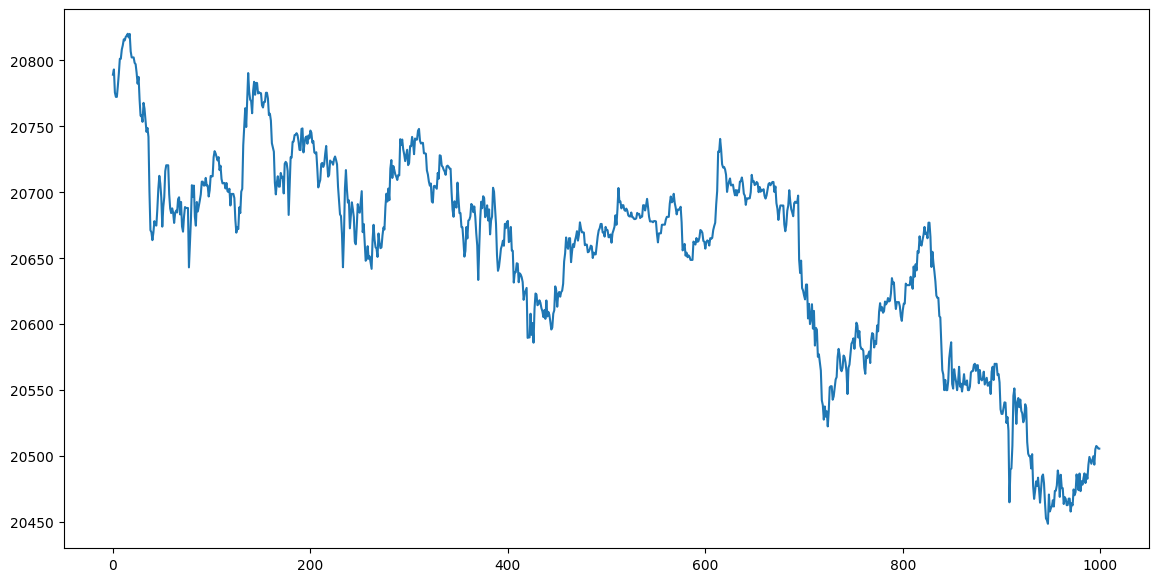

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
# 选择获取数据的时间间隔
perids = "60"
# 获取btc历史价格走势
params = {"perids":perids}
btc_price_data_json = requests.get("https://api.cryptowat.ch/markets/gemini/btcusd/ohlc", params).json()
print(btc_price_data_json)
df = pd.DataFrame(
    btc_price_data_json["result"][perids],
    columns=['CloseTime', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volume', 'NA']
)
# 输出df的头部head
print(df.head())
# 绘制btc价格走势曲线
df["ClosePrice"].plot(figsize=(14,7))
plt.show()

In [4]:
import requests
import timeit


def get_orderbook():
  orderbook = requests.get("https://api.gemini.com/v1/book/btcusd").json()

n = 10
latency = timeit.timeit('get_orderbook()', setup='from __main__ import get_orderbook', number=n) * 1.0 / n
print('Latency is {} ms'.format(latency * 1000))

Latency is 1242.3473115999514 ms


In [10]:
# websocket例子
import websocket
import _thread
import time


# 接收服务器的消息
def on_message(ws, message):
    print("Received: " + message)


# 与服务建立连接完成
def on_open(ws):
    # 线程运行函数
    def ws_send():
        # 依次发送0-4 没次发送完消息 sleep 0.01s
        for i in range(5):
            time.sleep(0.01)
            msg = f"{i}"
            ws.send(msg)
            print('Sent: ', msg)
        # 休眠1s用于接收服务器的消息
        time.sleep(1)

        # 关闭连接
        ws.close()
        print("Websocket Closed")

    # 在另一个线程运行ws_send函数
    _thread.start_new_thread(ws_send, ())


if __name__ == '__main__':
    ws = websocket.WebSocketApp("ws://echo.websocket.events/", on_message=on_message, on_open=on_open)
    ws.run_forever()


Received: echo.websocket.events sponsored by Lob.com
Sent:  0
Sent:  1
Sent:  2
Sent:  3
Sent:  4
Received: 0
Received: 1
Received: 2
Received: 3
Received: 4
Websocket Closed


In [11]:
# 行情数据抓取
import copy
import json
import ssl
import time
import websocket


class OrderBook(object):

    BIDS = 'bid'
    ASKS = 'ask'

    def __init__(self, limit=20):

        self.limit = limit

        # (price, amount)
        # 买方挂单
        self.bids = {}
        # 卖方挂单
        self.asks = {}

        # 排序后的买方挂单-top10
        self.bids_sorted = []
        # 排序后的卖方挂单-top10
        self.asks_sorted = []

    def insert(self, price, amount, direction):
        if direction == self.BIDS:
            if amount == 0:
                if price in self.bids:
                    del self.bids[price]
            else:
                self.bids[price] = amount
        elif direction == self.ASKS:
            if amount == 0:
                if price in self.asks:
                    del self.asks[price]
            else:
                self.asks[price] = amount
        else:
            print('WARNING: unknown direction {}'.format(direction))

    def sort_and_truncate(self):
        # sort
        self.bids_sorted = sorted([(price, amount) for price, amount in self.bids.items()], reverse=True)
        self.asks_sorted = sorted([(price, amount) for price, amount in self.asks.items()])

        # truncate
        self.bids_sorted = self.bids_sorted[:self.limit]
        self.asks_sorted = self.asks_sorted[:self.limit]

        # copy back to bids and asks
        self.bids = dict(self.bids_sorted)
        self.asks = dict(self.asks_sorted)

    def get_copy_of_bids_and_asks(self):
        return copy.deepcopy(self.bids_sorted), copy.deepcopy(self.asks_sorted)


class Crawler:
    def __init__(self, symbol, output_file):
        self.orderbook = OrderBook(limit=10)
        self.output_file = output_file

        self.ws = websocket.WebSocketApp('wss://api.gemini.com/v1/marketdata/{}'.format(symbol),
                                         on_message = lambda ws, message: self.on_message(message))
        self.ws.run_forever(sslopt={'cert_reqs': ssl.CERT_NONE})

    def on_message(self, message):
        # 对收到的信息进行处理，然后送给 orderbook
        data = json.loads(message)
        for event in data['events']:
            price, amount, direction = float(event['price']), float(event['remaining']), event['side']
            self.orderbook.insert(price, amount, direction)

        # 整理 orderbook，排序，只选取我们需要的前几个
        self.orderbook.sort_and_truncate()

        # 输出到文件
        with open(self.output_file, 'a+') as f:
            bids, asks = self.orderbook.get_copy_of_bids_and_asks()
            output = {
                'bids': bids,
                'asks': asks,
                'ts': int(time.time() * 1000)
            }
            f.write(json.dumps(output) + '\n')


if __name__ == '__main__':
    crawler = Crawler(symbol='BTCUSD', output_file='BTCUSD.txt')

In [ ]:
# 读取csv数据
import pandas as pd
import os


def assert_msg(condition, msg):
    if not condition:
        raise Exception(msg)


def read_csv_file(filename):
    # 获取文件绝对路径
    filepath = os.path.join(os.path.dirname(__file__), filename)
    # 判断文件是否存在
    assert_msg(os.path.exists(filepath), "file noe found")
    # 读取csv文件并返回
    return pd.read_csv(filepath, index_col=0, parse_dates=True, infer_datetime_format=True)


BTCUSD = read_csv_file("BTCUSD_GEMINI.csv")
assert_msg(BTCUSD.__len__() > 0, "read failed")
print(BTCUSD.head())